In [1]:
import numpy as np
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import chromadb
from deepface import DeepFace
from tqdm import tqdm

2024-06-08 03:21:51.297734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset = datasets.CelebA('../data', split='train', target_type='identity')

In [3]:
chroma_client = chromadb.PersistentClient(path='celeba.db')
collection = chroma_client.get_or_create_collection('celeba')

In [4]:
image_ids = {}
for idx, (img, identity) in enumerate(tqdm(dataset)):
    identity = identity.item()
    if identity in image_ids or identity > 100:
        continue
    img = np.array(img)
    img = img[:, :, [2, 1, 0]]  # deepface wants images in BGR format
    try:
        encoding = DeepFace.represent(img, model_name='Facenet', detector_backend='dlib')[0]['embedding']
    except ValueError as ve:
        print(ve)
        continue
    collection.upsert(ids=str(identity), embeddings=encoding)
    image_ids[identity] = idx

  3%|▎         | 4502/162770 [00:17<08:07, 324.89it/s]

Face could not be detected in numpy array.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


  5%|▍         | 7671/162770 [00:21<02:14, 1156.46it/s]

Face could not be detected in numpy array.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


  7%|▋         | 11615/162770 [00:26<02:45, 915.98it/s] 

Face could not be detected in numpy array.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


100%|██████████| 162770/162770 [01:15<00:00, 2152.69it/s]


In [5]:
test_identities = {1, 2, 3, 4, 35}
detected_identities = {}
test_ids = {}
for idx, (img, identity) in enumerate(dataset):
    identity = identity.item()
    if identity in test_identities and identity in image_ids and idx != image_ids[identity]:
        img = np.array(img)
        img = img[:, :, [2, 1, 0]]
        try:
            encoding = DeepFace.represent(img, model_name='Facenet', detector_backend='dlib')[0]['embedding']
        except ValueError as ve:
            print(ve)
            continue
        test_ids[identity] = idx
        detected_identity = int(collection.query(query_embeddings=encoding, n_results=1)['ids'][0][0])
        detected_identities[identity] = detected_identity
        test_identities.remove(identity)
        if not test_identities:
            break
assert not test_identities

35 35


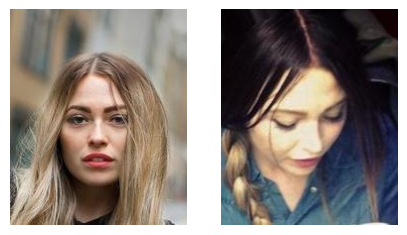

3 3


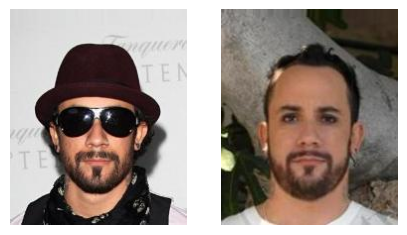

1 60


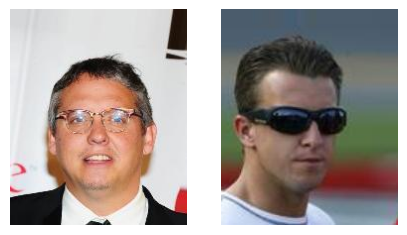

4 4


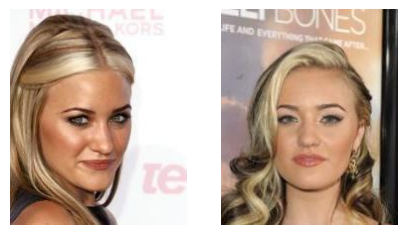

2 84


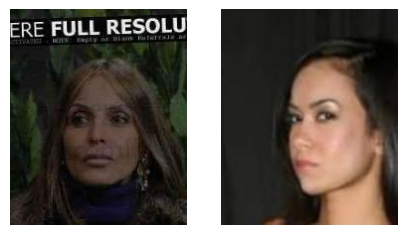

In [6]:
for identity, detected_identity in detected_identities.items():
    print(identity, detected_identity)
    db_img = dataset[image_ids[detected_identity]][0]
    test_img = dataset[test_ids[identity]][0]
    plt.figure(figsize=(5, 5))
    plt.subplot(121)
    plt.imshow(db_img)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(test_img)
    plt.axis('off')
    plt.show()